#**ArchaeoPyDating: examples of use**

In this Notebook we are going to show the steps followed to obtain the results obtained in the *Section 4.2: "Using the Python module: validation and limitations"* of the article. These examples serve as a guide of use of the ArchaeoPyDating Python module.

## **Installing and Importing the module**

The installation process may take some time (about a minute):

In [1]:
! pip install -q git+https://github.com/Mariossb/ArchaeoPyDating.git

  Preparing metadata (setup.py) ... done


In [2]:
import ArchaeoPyDating as apd

To know the available reference curves you can execute:

In [12]:
apd.available_psvc()


Local PSVCs:
- Iberia: Molina-Cardín et al. (2018) [D,I,F] [1000 BC - 1900 AD]
- Iberia (Iron Age): Osete et al. (2020) [D,I,F] [1100 BC - 100 BC]
- France (directional): Le Goff et al. (2020) [D,I] [70 BC - 1700 AD]
- France (intensity): Genevey et al. (2021) [F] [300 AD - 1850 AD]
- Western Europe (directional 1st millennium BC, Hervé et al. 2013): Hervé et al. (2013a) [D,I] [1500 BC - 200 AD]
- Western Europe (intensity 1st millennium BC, Hervé et al. 2013): Hervé et al. (2013b) [F] [1500 BC - 200 AD]
- Italy: Tema and Lanos (2021) [D,I,F] [900 BC - 1980 AD] (F only for [700 BC - 1800 AD])
- Great Britain (directional): Batt et al. (2017) [D,I] [6000 BC - 1980 AD]
- Bulgaria: Kovacheva et al. (2014) [D,I,F] [6000 BC - 1800 AC]
- Cyprus: Tema et al. (2021) [D,I] [2000 BC - 1900 AC]
- Azores: Béguin et al. (2020) [D,I,F] [500 BC - 2000 AD]
- Europe Neolithic (directional): Carrancho et al. (2013) [D,I] [6000 BC - 1000 AD]
- Hawaii: Tema et al. (2017) [D,I,F] [8000 BC - 1950 AD]
- New

## **Case Study**

In this example our focus will be on analyzing an archaeomagnetic dating study conducted on a medieval kiln located within the archaeological site of La Pudia (41.81ºN/3.45ºW, Burgos, Spain). The original study detailing this research can be accessed in García-Redondo et al. (2020) (https://doi.org/10.1007/s12520-020-01041-1).

For the selected kiln, a full-vector archaeomagnetic analysis was reported, yielding the following results:


*   D = 20.5º
*   I = 52.7º
*    α₉₅ = 2.1º
*   F = 53.9 μT
*   σF = 4.6 μT

Our initial step in utilizing the tool involves defining a Python object that represents this archaeological artifact:

In [3]:
artifact = apd.Data(
    D = 20.5,
    I = 52.6,
    a95 = 1.1,
    F = 53.9,
    eF = 4.6,
    lat = 41.81,
    lon = -3.45,
    sitename = "La Pudia"
)

To proceed with the archaeomagnetic dating process, it is essential to select a Paleosecular Variation Curve (PSVC) that describes the past evolution of the geomagnetic field elements at a certain location.

In this instance, we will utilize a PSVC derived from the European regional model SCHA.DIF.4k (Pavón-Carrasco et al. 2021) (https://doi.org/10.1029/2020JB021237).

Our next step involves creating another Python object, this time representing the reference curve. It's important to note that since the curve needs to be synthesized from a regional model, the coordinates for the target location (La Pudia) must be specified:

In [4]:
curve = apd.Curve(rmodel = "SCHA.DIF.4k", lat = artifact.lat, lon = artifact.lon)

When utilizing this object directly, the reference curve will be applied over its entire temporal range (in the case of the SCHA.DIF.4k model, the last 4000 years). However, if we wish to focus solely on a specific interval within this range, we can define it using the **int_temp(tmin,tmax)** function. Here, *tmin* and *tmax* represent the lower and upper limits, respectively, of the desired temporal interval.

For instance, in this scenario, we can narrow our analysis to the years Anno Domini (AD):

In [5]:
curve.int_temp(0, 1900)

Following the creation of Python objects for both the archaeological artifact and the reference curve, the next step is to generate an object that represents their combination. This combined object will facilitate further analysis and computations necessary for the archaeomagnetic dating process.

In [6]:
combination = apd.Dating(artifact, curve)

Using this combined object, we can derive the probability density functions (PDFs) for each geomagnetic element. These PDFs illustrate the comparison between the undated archaeomagnetic data and the reference curve:



In [7]:
zD = combination.datingX('D')    # for declination
zI = combination.datingX('I')    # for inclination
zF = combination.datingX('F')    # for intensity

These PDFs are defined from the minimum time of the curve (in this case, 0) to its upper limit (in this case, 1900) in steps of one year.

These PDFs for each geomagnetic element can be combained  to derive PDFs representing the joint comparison of two or three elements. For example, we create two combined PDFs:


1.   One representing directional dating
2.   The other representing full-vector dating



In [8]:
zDI = combination.zcomb(zD, zI)  # directional
zDIF = combination.zcomb(zD, zI, zF)  # full-vector

To compare the PDFs for these last two cases, along with the alleged case where only the intensity element is dated, we plot the corresponding PDFs:

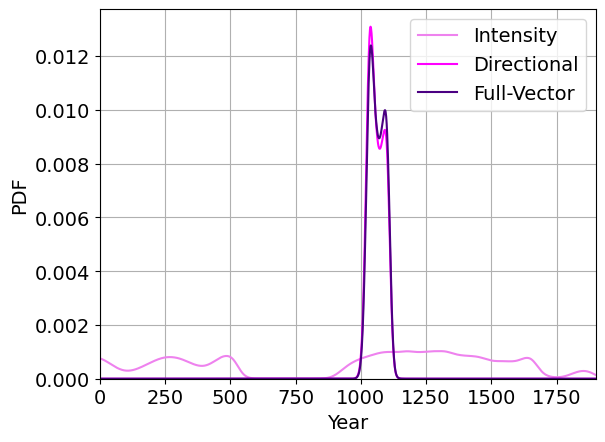

In [9]:
import matplotlib.pyplot as plt   # library for ploting
import numpy as np

fig = plt.figure()
plt.rcParams['font.size'] = 14

# temporal axis for plotting (from the minimum time of the curve to its upper limit in steps of one year)
t = np.arange(
    min(curve.t), max(curve.t)+1
)

plt.plot(t, zF, label = "Intensity",     color="violet")
plt.plot(t, zDI, label = "Directional",  color="magenta")
plt.plot(t, zDIF, label = "Full-Vector", color="indigo")

plt.xlabel('Year')
plt.ylabel('PDF')
plt.xlim(min(t), max(t))
plt.ylim(0, None)
plt.grid(True)
plt.legend()
plt.show()


We can also determine the corresponding dating intervals at a certain level of confidence (e.g., 95%) by calculating the corresponding thresholds. These thresholds represent the height at which the area enclosed by the PDF accounts for 95% of its total area, thus indicating the level of certainty associated with the dating interval.

In [10]:
cl = 95   # confidence level

# thresholds:
hF = combination.pb(zF, cl)
hDI = combination.pb(zDI, cl)
hDIF = combination.pb(zDIF, cl)

# results:
result_F = combination.pb_h(zF, hF)
result_DI = combination.pb_h(zDI, hDI)
result_DIF = combination.pb_h(zDIF, hDIF)

print("Intensity result:")
print(result_F)
print("Directional result:")
print(result_DI)
print("Full-Vector result:")
print(result_DIF)

Intensity result:
{'Dating result 1': [0, 105], 'Dating result 2': [110, 540], 'Dating result 3': [925, 1690]}
Directional result:
{'Dating result 1': [1010, 1115]}
Full-Vector result:
{'Dating result 1': [1010, 1115]}


Based on the figure and the dating results depicted above, we can make some observations:


*   Dating solely based on one geomagnetic field element (intensity) results in a wide temporal interval without a clearly defined dating range. This is a very common situation when dating with only one geomagnetic field element. In such instances, archaeomagnetic dating can offer a possible age interval estimation but lacks precision for age determination.
*   In this scenario, both directional and full-vector dating cases yield similar results. This coherence arises because, in this case, the directional information alone is adequate to establish a unique dating interval. However, it's worth noting that this may not always be the case. In situations where directional data presents multiple potential time intervals, incorporating the intensity element helps in eliminating some of these intervals, leading to a more refined dating outcome.



Following with this example, we can illustrate here the dating of the same material/object using different reference curves. Given the archaeological site location and the target temporal interval, we may choose different reference curves to conduct the dating:


1.   **Local PSVC for Iberia**: We can utilize the PSVC defined for the Iberian Peninsula by Molina-Cardín et al. (2018) (https://doi.org/10.1029/2018GC007781).
2.   **European Regional Model**: Another option is to synthesize a PSVC from a European regional model, such as the SCHA.DIF.4k (Pavón-Carrasco et al., 2021) (https://doi.org/10.1029/2020JB021237), which is in fact the model used in the precedent examples.
3. **Global Model**: Alternatively, we can synthesize a PSVC from a global model, such as the SHAWQ2k (Campuzano et al., 2019) (https://doi.org/10.1016/j.epsl.2019.01.050). This model is particularly suitable for our artifact due to the database used for its construction (many data comming from Iberia) and its defined temporal interval.



In [11]:
curve1 = apd.Curve(local = "Iberia")
curve2 = apd.Curve(rmodel = "SCHA.DIF.4k", lat=artifact.lat, lon=artifact.lon)
curve3 = apd.Curve(gmodel = "SHAWQ2k", lat=artifact.lat, lon=artifact.lon)

# make an object with the three reference curves
curves = [curve1, curve2, curve3]

# define the same time interval for the three
for curvei in curves:
  curvei.int_temp(0, 1900)

It's important to note that when synthesizing the PSVC from a model (regional or global), we need to specify the location for which we want to synthesize the curve. However, this isn't necessary for the local curve, as it is already defined for a specific location. In this scenario, we must relocate the archaeomagnetic direction/intensity of the artifact to match that specific location.

With this consideration in mind, we proceed to create the objects by combining the archaeological artifact and the reference curves:

In [13]:
from copy import copy   # (a function we will use)

combinations = []

for curvei in curves:

  # if the curve is local, relocate data
  if curvei == curve1:
    artifact_relocated = copy(artifact)
    artifact_relocated.cvp(curvei.lat, curvei.lon)   # conversion via pole (CVP) of the archaeomagnetic directions
    artifact_relocated.vdm()                         # translate intensity data using virtual dipole moment (VDM)

    combinationi = apd.Dating(artifact_relocated, curvei)


  # if using a regional/global model, use directly the data
  else:
    combinationi = apd.Dating(artifact, curvei)

  combinations.append(combinationi)


With the combinations created, we can now proceed to calculate the PDFs representing the archaeomagnetic dating results with each of the curves. For this analysis, we will utilize the full-vector dating:

In [14]:
zD, zI, zF = [], [], []
z = []

for combinationi in combinations:
    zDi = combinationi.datingX('D')
    zIi = combinationi.datingX('I')
    zFi = combinationi.datingX('F')
    zi = combinationi.zcomb(zDi, zIi, zFi)

    zD.append(zDi), zI.append(zIi), zF.append(zFi)
    z.append(zi)

By plotting the PDFs and displaying the corresponding results at 95% confidence, we can compare the dating obtained with each of the reference curves:

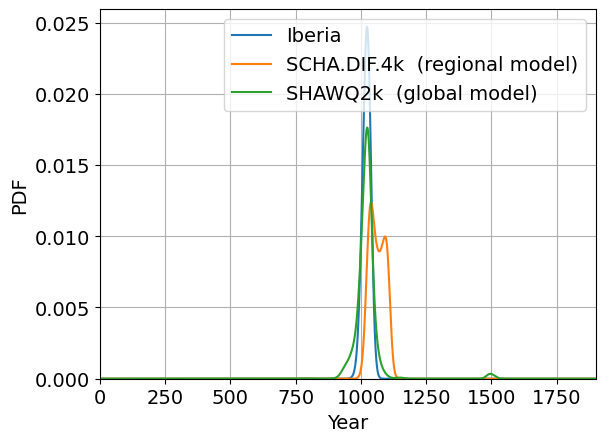

Result for Iberia:
{'Dating result 1': [990, 1050]}
Result for SCHA.DIF.4k  (regional model):
{'Dating result 1': [1010, 1115]}
Result for SHAWQ2k  (global model):
{'Dating result 1': [940, 1080]}


In [15]:
## FIGURE ##

fig = plt.figure()


for i in range(3):

  # temporal axis for plotting (from the minimum time of the curve to its upper limit in steps of one year)
  t = np.arange(
      min(curves[i].t), max(curves[i].t)+1
  )

  plt.plot(t, z[i], label = curves[i].name)


plt.xlabel('Year')
plt.ylabel('PDF')
plt.xlim(min(t), max(t))
plt.ylim(0, None)
plt.grid(True)
plt.legend()
plt.show()


## DATING RESULTS ##

cl = 95   # confidence level

for i in range(3):

  # threshold:
  h = combinations[i].pb(z[i], cl)
  # result:
  result = combinations[i].pb_h(z[i], h)
  print("Result for "+curves[i].name+":")
  print(result)

In this dating case, the three selected reference curves produce similar and compatible dating estimations, all indicating an age for the artifact within the range of the 11th century. The SCHA.DIF.4k regional model yields the broader time interval, with results slightly shifted to younger ages compared to the other two curves. Conversely, the results obtained from the local curve and the global model SHAWQ2k almost coincide, with the local curve providing the narrower time interval estimation.

This convergence of results among different curves or models may not always occur, especially if outdated curves or models are utilized, or if the past evolution of the geomagnetic field in the target region is not well-constrained due to a scarcity of prior archaeomagnetic data that serves as input for model construction. This last situation is particularly plausible in regions of the southern hemisphere, where the availability of archaeomagnetic data is notably limited.